In [3]:
##  Data Set:  Multi PIE  (Multi Pose, Illumination, Expressions)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import glob
import pandas as pd
import random
import numpy as np
import cv2
import base64
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm
from pprint import pprint
from PIL import Image
from time import localtime, strftime
from sklearn.model_selection import train_test_split
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cuda


In [4]:
import random
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
import copy
import os
#import random
import shutil
#import time
from zipfile import ZipFile
import  pathlib
from os import walk
import time
from datetime import datetime


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# create folder in runtime env
pathlib.Path('./MultiPIE/train').mkdir(parents=True, exist_ok=True)

pathlib.Path('./MultiPIE/test').mkdir(parents=True, exist_ok=True)

In [8]:
# Unzip the color.zip file from google drive to the current runtime for faster access.
zipped_data_file_name = '/content/drive/MyDrive/major_project/data/train_jan22.zip'
with ZipFile(zipped_data_file_name, 'r') as zip_ref:
    zip_ref.extractall(path= '/content/MultiPIE/train')

In [9]:
# Unzip the color.zip file from google drive to the current runtime for faster access.
zipped_data_file_name = '/content/drive/MyDrive/major_project/data/test_jan22.zip'
with ZipFile(zipped_data_file_name, 'r') as zip_ref:
    zip_ref.extractall(path= '/content/MultiPIE/test')

In [10]:
TRAIN_DATASET_PATH ="/content/MultiPIE/train"
TEST_DATASET_PATH ="/content/MultiPIE/test"


In [11]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader, random_split


In [12]:
IMAGE_SIZE = 160
BATCH_SIZE = 2

In [13]:

# 219_01_02_051_07.png
# 219 is person
# 01 - session
# 02 - expression (1 : neutral, smile   2 : neutral, surprise, squint  3 : neutral, smile, disgust 4 : neutral, neutral, scream.)
# 051 - camera
# 07 - illumination

# Camera:
# 051 - front looking -> base image  use attribute 4 (middle)

# When viewed from back in pic above:
# Left side 3 cameras:
# 080 use attribute 1
# 130 use attribute 2
# 140 use attribute 3
# Right side 3 cameras:
# 050 use attribute 5
# 041 use attribute 6
# 190 use attribute 7

#------------- Flash light illumination:
# 4 flash at camera 080
# 5 flash at camera 130
# 6 flash at camera 140
# 7 flash at camera 051
# 8 flash at camera 050
# 9 flash at camera 041
# 10 flash at camera 190

#15,16,17 flashes are above head and not realted to any camera

#face_0 = listing[0]

camera_positions = ['080', '130','140','051','050','041','190',]
#flash_positions =  ['04','05','06','07','08','09','10',]
flash_positions =  ['04','05','06','08','09','10',]  # dont use the flash at camera 51


In [14]:
# values = [1,2,3,4,5,6,7]
# n_values = np.max(values) + 1
# one_hot_arr = np.eye(n_values)[values]

values = [1,2,3,4,5,6,7]
n_values = np.max(values) + 1
# one_hot_arr = np.eye(n_values)[values]
one_hot_arr = torch.eye(n_values,dtype=torch.float32)
print(one_hot_arr.dtype)
print(one_hot_arr.requires_grad)
train_images_count = 0

torch.float32
False


In [15]:
# ####   This   one creates data which moves straight looking face
# #### to other angles.
# Step 1. Train for:

#    3->0
#    3->1
#    3->2
#    3->4
#    3->5
#    3->6


# """
#  We do not need to divide by 255, the MultiPIE  data set is already 0.0 - 1.0

# """

import glob


class ClampTransform(object): #nn.Module):
    def __init__(self, min_value, max_value):
        super().__init__()
        self.min = min_value
        self.max = max_value

    #def forward(self, tensor1):
    def __call__(self, tensor1):
        return torch.clamp(tensor1, min=self.min, max=self.max)

clamp_transform = ClampTransform(0.005, 0.995)

class MultiPIE_DS1_Tilt2Angles(Dataset):
    def __init__(self, image_dir):
        super().__init__()
        #self.dsname = image_dir
        self.transform = transforms.Compose([
                 # torchvision.transforms.Normalize()  does it reduce the clarity?
                 # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

                 transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                 transforms.ToTensor(),
                 ClampTransform(0.005, 0.995),
        ])

        self.dir = image_dir
        #self.imgs = os.listdir(image_dir)
        self.imgs = glob.glob( self.dir +  '/*_051_*.png')
        self.length = len(self.imgs)
        #print(f'{self.length=}')

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        global train_images_count

        # # if torch.is_tensor(idx):
        # #     idx = idx.tolist()
        # print(f'{idx=}')

        ##print(f' trying to get record number: {i} {self.dsname}')

        face_0_filename = self.imgs[idx]
        #print(f' face_0_filename = {face_0_filename}')
        face_0_parts = face_0_filename.split('_051_')

        target_images = []
        target_onehot = []
        target_file_names=[]


        for j in range(7):  # allow 0,1,2 and 4,5,6  (the last entry of the tensor is unused as of now....
          #print(f'- {j} ->',end='')

          if j == 3:  # 3-> straight looking camera used as source
            #print('')
            continue


          tgt_filename = face_0_parts[0]+'_'+camera_positions[j]+'_'+face_0_parts[1]
          if os.path.isfile(tgt_filename):
              #target_images.append( self.transform(Image.open( tgt_filename )) )

             img_group = Image.open( tgt_filename )

             if img_group.mode == 'RGBA':
                    img_group = img_group.convert('RGB')

             target_images.append( self.transform(img_group) )

              # # #target_file_names.append(tgt_filename)
              # print(f'{face_0_filename=}  {tgt_filename=}')
              # print(f' -- found,  so one_hot_arr index will be :  {j} ' )
             target_onehot.append( one_hot_arr[j] )


          # #-----------------------------
          # #  the below can be used for all the 6 flash positions,
          # # with single light source
          # for flash_pos in range(len(flash_positions)):

          #       #tgt_filename = face_0_parts[0]+'_'+camera_positions[j]+'_'+face_0_parts[1]
          #       tgt_filename = face_0_parts[0]+'_'+camera_positions[j]+'_'+ flash_positions[flash_pos] + '.png'

          #       #print(f' tgt_filename = {tgt_filename}' , end='')

          #       if os.path.isfile(tgt_filename):
          #           target_images.append( self.transform(Image.open( tgt_filename )) )
          #           # # #target_file_names.append(tgt_filename)
          #           # print(f'{face_0_filename=}  {tgt_filename=}')
          #           # print(f' -- found,  so one_hot_arr index will be :  {j} ' )
          #           target_onehot.append( one_hot_arr[j] )
          # #-----------------------------



        src_imgs = [ self.transform(Image.open( self.imgs[idx])) ] * len(target_images)
        #output_img = self.transform(Image.open(self.dir + self.imgs[i]))
        #print(output_img)
        #return output_img
        train_images_count += len(src_imgs)
        return  src_imgs,  target_images  , target_onehot  #,target_file_names



In [16]:
# ### this dataset creates data which moves other angle images to straightlooking....
# ###  so from the previous(above) dataset, src_imgs and tgt_imgs will be swapped.
# ###  Target Vectors has to be reversed, so that we can use previous checkpoints and apply transfer learning???

# # Step 2. Train for:

# #    0->3
# #    1->3
# #    2->3
# #    4->3
# #    5->3
# #    6->3


# """
#  We do not need to divide by 255, the MultiPIE  data set is already 0.0 - 1.0
# """
# import glob

# class ClampTransform(object): #nn.Module):
#     def __init__(self, min_value, max_value):
#         super().__init__()
#         self.min = min_value
#         self.max = max_value

#     #def forward(self, tensor1):
#     def __call__(self, tensor1):
#         return torch.clamp(tensor1, min=self.min, max=self.max)

# clamp_transform = ClampTransform(0.005, 0.995)

# class MultiPIE_DS1_Move2Straight(Dataset):
#     def __init__(self, image_dir):
#         super().__init__()
#         #self.dsname = image_dir
#         self.transform = transforms.Compose([
#                  # torchvision.transforms.Normalize()  does it reduce the clarity?
#                  # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

#                  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#                  transforms.ToTensor(),
#                  ## #clamp_transform(), do not call this instance, since it calls the __call__ directly and tensor param is missing. Instead mention the class as below
#                  ClampTransform(0.005, 0.995),
#         ])

#         self.dir = image_dir
#         #self.imgs = os.listdir(image_dir)
#         self.imgs = glob.glob( self.dir +  '/*_051_*.png')
#         self.length = len(self.imgs)
#         #print(f'{self.length=}')

#     def __len__(self):
#         return self.length

#     def __getitem__(self, idx):
#         global train_images_count

#         # # if torch.is_tensor(idx):
#         # #     idx = idx.tolist()
#         # print(f'{idx=}')

#         ##print(f' trying to get record number: {i} {self.dsname}')

#         face_0_filename = self.imgs[idx]
#         #print(f' face_0_filename = {face_0_filename}')
#         face_0_parts = face_0_filename.split('_051_')

#         target_images = []
#         target_onehot = []
#         target_file_names=[]


#         for j in range(7):  # allow 0,1,2 and 4,5,6  (the last entry of the tensor is unused as of now....
#           #print(f'- {j} ->',end='')


#           if j == 3:  # 3-> straight looking camera used as source
#             #print('')
#             continue


#           tgt_filename = face_0_parts[0]+'_'+camera_positions[j]+'_'+face_0_parts[1]
#           if os.path.isfile(tgt_filename):

#              img_group = Image.open( tgt_filename )
#              if img_group.mode == 'RGBA':
#                     img_group = img_group.convert('RGB')

#               target_images.append( self.transform(img_group) )

#               # # #target_file_names.append(tgt_filename)
#               # print(f'{face_0_filename=}  {tgt_filename=}')
#               # print(f' -- found,  so one_hot_arr index will be :  {j} ' )

#               #target_onehot.append( one_hot_arr[j] ) # Feb 7,2025
#               #target_onehot.append( one_hot_arr[6-j] ) # Feb 7,2025
#               target_onehot.append( one_hot_arr[3] ) # Feb 7,2025


#           # #-----------------------------
#           # # Feb 5, 2025, the below can be used for all the 6 flash positions, we have already trained 2 epochs and then commented to continue
#           # # with single light source
#           # for flash_pos in range(len(flash_positions)):

#           #       #tgt_filename = face_0_parts[0]+'_'+camera_positions[j]+'_'+face_0_parts[1]
#           #       tgt_filename = face_0_parts[0]+'_'+camera_positions[j]+'_'+ flash_positions[flash_pos] + '.png'

#           #       #print(f' tgt_filename = {tgt_filename}' , end='')

#           #       if os.path.isfile(tgt_filename):
#           #           target_images.append( self.transform(Image.open( tgt_filename )) )
#           #           # # #target_file_names.append(tgt_filename)
#           #           # print(f'{face_0_filename=}  {tgt_filename=}')
#           #           # print(f' -- found,  so one_hot_arr index will be :  {j} ' )
#           #           target_onehot.append( one_hot_arr[j] )
#           # #-----------------------------



#         src_imgs = [ self.transform(Image.open( self.imgs[idx])) ] * len(target_images)
#         #output_img = self.transform(Image.open(self.dir + self.imgs[i]))
#         #print(output_img)
#         #return output_img
#         train_images_count += len(src_imgs)

#         #return  src_imgs,  target_images  , target_onehot  #,target_file_names
#         return   target_images, src_imgs  , target_onehot





In [17]:
def get_dataloaders():

    train_ds = MultiPIE_DS1_Tilt2Angles('/content/MultiPIE/train/')
    test_ds = MultiPIE_DS1_Tilt2Angles('/content/MultiPIE/test/')

    # train_ds, test_ds = random_split(celeb_a, [0.8, 0.2])
    # print('Train data size: {}'.format(len(train_ds)))
    # print('Test data size: {}'.format(len(test_ds)))

    train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    test_loader =  DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    print(f' train_ds.length={train_ds.length}  - test_ds.length={test_ds.length}  ')

    return train_loader, test_loader

In [18]:
#  _,test_loader = get_dataloaders()
# # _ = next(iter(train_loader))   # 038_01_02_051_11   person_session_expression_camera_illumination
# train_images_count


In [19]:
# # Check dataset
# _ , check_ds = get_dataloaders()
# #check_samples = next(iter(check_ds))

# src_imgs,  target_images  , targets_onehot  = next(iter(check_ds))
# print(f' --> {len(src_imgs)}')
# src_imgs = torch.stack(src_imgs)
# src_imgs = src_imgs.reshape(-1,3,160,160)
# target_images = torch.stack(target_images)
# target_images = target_images.reshape(-1,3,160,160)
# targets_onehot = torch.stack(targets_onehot)
# targets_onehot = targets_onehot.reshape(-1,8)
# targets_onehot = targets_onehot.float()

# # print(src_imgs.shape)
# # print(target_images.shape)
# # print(targets_onehot.shape)

# fig = plt.figure(figsize=(84, 80))

# grid = ImageGrid(fig, 111,  # similar to subplot(111)
#                  nrows_ncols=(16, 2),  # creates 2x2 grid of Axes
#                  axes_pad=0.1,  # pad between Axes in inch.
#                  )

# img_array = []

# for i in range(2):
#   #  img_array.append(src_imgs[i].permute(1, 2, 0).clamp(0.0, 1.0) )
#   #  img_array.append(target_images[i].permute(1, 2, 0).clamp(0.0, 1.0) )

#    img_array.append(src_imgs[i].permute(1, 2, 0) )
#    img_array.append(target_images[i].permute(1, 2, 0))



# for ax, im in zip(grid, img_array ):
#     # Iterating over the grid returns the Axes.
#     ax.imshow(im)


# plt.show()

In [20]:
train_dataloader, test_dataloader = get_dataloaders()

 train_ds.length=7164  - test_ds.length=1800  


In [21]:
DIM_X = 160
DIM_Y = 160

IMAGE_H = 160
IMAGE_W = 160
N_CHANNELS = 3

In [22]:
class EncoderDecoder(nn.Module):


    def __init__(self ) -> None:

        super().__init__()

        self.image_encoder = nn.Sequential(

                    # jan 26 -ref to the paper https://stephenjia.github.io/xjia_publications/xjia_bmvc16_facefinal.pdf
                    # They took inspiration from oxfordNet and mention that 2 consecutive conv layers  increase receptive field?

                    nn.Conv2d( 3 , 128 , 3 , 1 , 1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),


                    nn.Conv2d( 128 , 128 , 3 , 1 , 1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),

                    #------

                    nn.Conv2d( 128 , 256 ,  3, 2 , 1),    # 160 -> 80
                    nn.BatchNorm2d(256),
                    nn.ReLU(),

                    nn.Conv2d( 256 , 256 , 3 , 1 , 1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),

                    nn.Conv2d( 256 , 256 , 3 , 1 , 1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),

                    #------


                    # nn.Conv2d( 256 , 512 , 3 , 2 , 1),    # 80 -> 40
                    # nn.BatchNorm2d(512),
                    # nn.ReLU(),


                    # nn.Conv2d( 512 , 512 , 3 , 1 , 1),
                    # nn.BatchNorm2d(512),
                    # nn.ReLU(),


                    # nn.Conv2d( 512 , 512 , 3 , 1 , 1),
                    # nn.BatchNorm2d(512),
                    # nn.ReLU(),

        )

        # We could also use an embedding vector
        # difference between Embedding and Linear: Linear expects vectors (e.g. one-hot representation of the words),
        # Embedding expects tokens (e.g. words index)
        # Ref https://discuss.pytorch.org/t/how-does-nn-embedding-work/88518/2

        # lets make 8 feature maps from attributes, so we need 40*40*8 neurons in the 2nd layer
        self.attribute_encoder = nn.Sequential(
                    nn.Linear(8, 512),
                    #nn.Dropout(p=0.01), this is an embedding creator, so drop???
                    nn.Linear(512, 80 * 80 * 32, bias=True),
        )


        self.fusion_net = nn.Sequential(  # input 40*40 * 288 (256+32)

                    # --------------
                    nn.Conv2d( 288 , 256 , 3 , 1 , 1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),

                    nn.Conv2d( 256 , 256 , 3 , 1 , 1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),

                    nn.Conv2d( 256 , 256 , 3 , 1 , 1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),


           )

        self.image_decoder = nn.Sequential(

                    # nn.ConvTranspose2d( 512 , 256 ,  kernel_size=4, stride = 2, padding=1, output_padding=0 , bias=True), # 40 -> 80
                    # nn.BatchNorm2d(256),
                    # nn.ReLU(),

                    # nn.Conv2d( 256 , 256 , 3 , 1 , 1),
                    # nn.BatchNorm2d(256),
                    # nn.ReLU(),

                    # nn.Conv2d( 256 , 256 , 3 , 1 , 1),
                    # nn.BatchNorm2d(256),
                    # nn.ReLU(),

                    #=====================


                    nn.ConvTranspose2d( 256 , 128 ,  kernel_size=4, stride = 2, padding=1, output_padding=0 , bias=True), # 80 -> 160
                    nn.BatchNorm2d(128),
                    nn.ReLU(),

                    nn.Conv2d( 128 , 128 , 3 , 1 , 1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),


                    nn.Conv2d( 128 , 128 , 3 , 1 , 1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),

                    #=======

                    nn.Conv2d( 128 , 3 , 3 , 1 , 1),
                    nn.BatchNorm2d(3),
                    nn.ReLU(),

                )




    def forward(self, src_imgs  , targets_onehot ):  #target_images

        encoded_images  = self.image_encoder(src_imgs)

        #print(f' --->>>>  targets_onehot.dtype = {targets_onehot.dtype}')
        ### output  --->>>>  targets_onehot.dtype = torch.float64  This is causing problem. some how the weights are double?

        encoded_attribs = self.attribute_encoder(targets_onehot)
        # print(f'encoded_images = {encoded_images.shape}')
        # print(f'encoded_attribs = {encoded_attribs.shape}')

        encoded_attribs  =  encoded_attribs.view(-1, 32 , 80, 80 )
        # print(f'encoded_attribs after view = {encoded_attribs.shape}')

        stacked_info    = torch.cat((encoded_images , encoded_attribs),1)  # channel wise concat???
        # print(f'stacked_info = {stacked_info.shape}')
        encoded_info    = self.fusion_net(stacked_info )

        result_images  = self.image_decoder(encoded_info)

        return result_images

    def loss_function(self, result_images , target_images , alpha=1 ) :

        assert result_images.size(dim=0) ==  target_images.size(dim=0)

        recons_loss =F.mse_loss(result_images, target_images)
        #recons_loss = F.l1_loss(result_images, target_images) # jan 31 , trial


        recons_loss = recons_loss * alpha

        #print(f' recons_loss.requires_grad : {recons_loss.requires_grad} , ')

        return { 'recons_loss' : recons_loss }


In [23]:
should_load_EncoderDecoder = True


In [24]:
def weights_init(m):
    classname = m.__class__.__name__
    #print(f'{classname=}')

    if classname.find('Conv') != -1:
        #nn.init.normal_(m.weight.data, 0.01, 0.001)  #https://homepage.divms.uiowa.edu/~mbognar/applets/normal.html
        nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0.0)

    elif classname.find('Linear') != -1:
        #nn.init.normal_(m.weight.data, 0.01, 0.010)
        nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0.0)

    elif classname.find('Norm') != -1:
        print(f'{classname} - Norm ???? .....')
        nn.init.normal_(m.weight.data, 0.1, 0.001)
        nn.init.constant_(m.bias.data, 0.0)
    else:
        print(f'{classname} - could not initialize.....')


model1 = EncoderDecoder()

if should_load_EncoderDecoder:
      state1 = torch.load("/content/drive/MyDrive/major_project/models/feb12_straight_2_angles_7_2_baselined.pth", weights_only=True, map_location=DEVICE)
      model1.load_state_dict(state1)   #['state_dict'])
      pass
else:
      model1.apply(weights_init)
      # for p in model_vae.parameters():
      #       nn.init.normal_(p,0,0.0001)

model1.to(DEVICE)



EncoderDecoder(
  (image_encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (attribute_encoder): Sequenti

In [25]:
DEVICE

device(type='cuda')

In [ ]:
def fit_epoch_model1(model1, optimizer1, batch_size, is_cnn=False):

    running_loss = 0.0
    processed_data = 0

    model1.train()

    ckpt_counter = 0

    #for inputs in next(iter(train_dataloader)) : # get_batch(train_x,batch_size):
    for i, inputs in enumerate(train_dataloader):

        ckpt_counter +=  1
        if ckpt_counter % 500 == 0:
                 torch.save(model1.state_dict(), '/content/drive/MyDrive/major_project/models/model1_ckptstep_' + str(ckpt_counter) + '_.pth')


        #-------------------
        src_imgs,  target_images  , targets_onehot  = inputs  # next(iter(check_ds))

        src_imgs = torch.stack(src_imgs)
        src_imgs = src_imgs.reshape(-1,3,160,160)

        target_images = torch.stack(target_images)
        target_images = target_images.reshape(-1,3,160,160)

        targets_onehot = torch.stack(targets_onehot)
        targets_onehot = targets_onehot.reshape(-1,8)
        targets_onehot = targets_onehot.float()


        src_imgs = src_imgs.to(DEVICE)
        target_images = target_images.to(DEVICE)
        targets_onehot = targets_onehot.to(DEVICE)


        #-------------------------

        #inputs = inputs.to(DEVICE)
        with torch.set_grad_enabled(True):

                    optimizer1.zero_grad()

                    #print(f'src_imgs.device = {src_imgs.device}')

                    result_images  = model1(src_imgs,targets_onehot  )

                    loss_dict = model1.loss_function( result_images , target_images ,alpha=1000 )
                    loss = loss_dict['recons_loss']

                    print(f" Reconstruction_Loss :  {loss.item()}    ")

                    loss.backward()
                    optimizer1.step()

        running_loss += loss.item() *  src_imgs.size(0)  # inputs.shape[0]
        processed_data +=  src_imgs.size(0)   #inputs.shape[0]

    train_loss = running_loss / processed_data
    return train_loss

def eval_epoch_vae_model1(model1, batch_size):

    running_loss = 0.0
    processed_data = 0
    model1.eval()

    for i, inputs in enumerate(test_dataloader):

          src_imgs,  target_images  , targets_onehot  = inputs  # next(iter(check_ds))

          src_imgs = torch.stack(src_imgs)
          src_imgs = src_imgs.reshape(-1,3,160,160)
          target_images = torch.stack(target_images)
          target_images = target_images.reshape(-1,3,160,160)
          targets_onehot = torch.stack(targets_onehot)
          targets_onehot = targets_onehot.reshape(-1,8)
          targets_onehot = targets_onehot.float()

          src_imgs = src_imgs.to(DEVICE)
          target_images = target_images.to(DEVICE)
          targets_onehot = targets_onehot.to(DEVICE)


          with torch.set_grad_enabled(False):

                    result_images  = model1(src_imgs,targets_onehot  )

                    loss_dict = model1.loss_function( result_images , target_images ,alpha=1000  )
                    loss = loss_dict['recons_loss']

                    print(f" test_Loss :  {loss.item()}    ")

          running_loss += loss.item() *  src_imgs.size(0)  # inputs.shape[0]
          processed_data +=  src_imgs.size(0)   #inputs.shape[0]


    val_loss = running_loss / processed_data
    return val_loss


def train_model1(  model1, epochs , batch_size , lr ):

    optimizer1 = torch.optim.Adam(model1.parameters(), lr=lr)
    history = []
    log_template = "\n ---- Epoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f} ----- \n "

    counter = 0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss = fit_epoch_model1(model1,optimizer1,batch_size)
            val_loss = eval_epoch_vae_model1(model1,batch_size)

            #print("loss: ", train_loss)
            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))

            counter += 1
            if counter % 1 == 0:
                  torch.save(model1.state_dict(), '/content/drive/MyDrive/major_project/models/feb12_straight_2_angles_' + str(int(val_loss)) + '_' + str(counter) + '.pth')

    return history


should_train_model1  = True
#--------
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)
#----------
if should_train_model1:

    history_model1 = train_model1( model1, epochs=3, batch_size=BATCH_SIZE, lr=0.00001)

    # # Save the model
    # str1 = strftime("%Y_%m_%d_%H_%M_%S", localtime())
    # torch.save(model1.state_dict(), '/content/drive/MyDrive/wip_new_model/models/V8feb11_model1_towards_straight_eod_' + str1 + '.pth')

    # plot metrics
    train_loss, val_loss = zip(*history_model1)
    plt.figure(figsize=(15,10))
    plt.plot(train_loss, label='Train loss')
    plt.plot(val_loss, label='Val loss')
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.plot()


Current Time = 11:53:18


epoch:   0%|          | 0/3 [00:00<?, ?it/s]

 Reconstruction_Loss :  16.96402359008789    
 Reconstruction_Loss :  15.130080223083496    
 Reconstruction_Loss :  6.29844856262207    
 Reconstruction_Loss :  7.042094707489014    
 Reconstruction_Loss :  10.917451858520508    
 Reconstruction_Loss :  8.571056365966797    
 Reconstruction_Loss :  6.223897457122803    
 Reconstruction_Loss :  6.449606418609619    
 Reconstruction_Loss :  5.837635517120361    
 Reconstruction_Loss :  10.157026290893555    
 Reconstruction_Loss :  6.770105361938477    
 Reconstruction_Loss :  5.432330131530762    
 Reconstruction_Loss :  5.198439598083496    
 Reconstruction_Loss :  7.891504287719727    
 Reconstruction_Loss :  7.235548496246338    
 Reconstruction_Loss :  5.842698574066162    
 Reconstruction_Loss :  11.364579200744629    
 Reconstruction_Loss :  18.0239315032959    
 Reconstruction_Loss :  5.543978214263916    
 Reconstruction_Loss :  4.766655921936035    
 Reconstruction_Loss :  7.027462005615234    
 Reconstruction_Loss :  5.523662

epoch:  33%|███▎      | 1/3 [40:31<1:21:03, 2431.92s/it]

 test_Loss :  5.79197883605957    

 ---- Epoch 001 train_loss: 8.0816 val_loss: 7.3348 ----- 
 
 Reconstruction_Loss :  6.218386650085449    
 Reconstruction_Loss :  8.95218276977539    
 Reconstruction_Loss :  5.4205121994018555    
 Reconstruction_Loss :  6.443673610687256    
 Reconstruction_Loss :  14.094738960266113    
 Reconstruction_Loss :  5.465970993041992    
 Reconstruction_Loss :  11.795428276062012    
 Reconstruction_Loss :  5.530642509460449    
 Reconstruction_Loss :  7.8418755531311035    
 Reconstruction_Loss :  6.438510894775391    
 Reconstruction_Loss :  6.907166004180908    
 Reconstruction_Loss :  6.6855645179748535    
 Reconstruction_Loss :  6.334161758422852    
 Reconstruction_Loss :  6.6338629722595215    
 Reconstruction_Loss :  5.6039652824401855    
 Reconstruction_Loss :  7.3638153076171875    
 Reconstruction_Loss :  6.848587512969971    
 Reconstruction_Loss :  11.184971809387207    
 Reconstruction_Loss :  5.2844743728637695    
 Reconstruction_Loss

In [ ]:
#============== testing code

In [ ]:
def test_vae(model1,  X_test):

    model1.eval()


    src_imgs,  target_images  , targets_onehot  = X_test  # next(iter(check_ds))

    src_imgs = torch.stack(src_imgs)
    src_imgs = src_imgs.reshape(-1,3,160,160)
    target_images = torch.stack(target_images)
    target_images = target_images.reshape(-1,3,160,160)
    targets_onehot = torch.stack(targets_onehot)
    targets_onehot = targets_onehot.reshape(-1,8)
    targets_onehot = targets_onehot.float()

    src_imgs = src_imgs.to(DEVICE)
    target_images = target_images.to(DEVICE)
    targets_onehot = targets_onehot.to(DEVICE)

    with torch.set_grad_enabled(False):
                 result_images  = model1(src_imgs,targets_onehot  )

    #print(recon_batch.shape)
    recon_images = result_images.permute(0, 2, 3, 1).contiguous() # 0 1 2 3
    original_images = src_imgs.permute(0, 2, 3, 1).contiguous() # 0 1 2 3


    recon_images    = recon_images.clone().detach().cpu().numpy()  # Reshape for images
    original_images =   original_images.clone().detach().cpu().numpy()  # Original images

    #print(recon_images.min())
    return original_images, recon_images

In [ ]:
def plot_reconstructions(original_images, recon_images, num_samples=10):

    # Determine the number of samples to plot (minimum of available images and requested samples)
    num_samples = min(num_samples, original_images.shape[0], recon_images.shape[0])

    fig=plt.figure(figsize=(10, 5))

    for i in range(num_samples):

        # Plot original images
        plt.subplot(2, num_samples, i + 1)
        #img = Image.fromarray((test_data_np * 255).astype(np.uint8))

        plt.imshow( (original_images[i] * 255).astype(np.uint8) )
        plt.axis('off')
        plt.title("Original")

        # Plot reconstructed images
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow( (recon_images[i] * 255).astype(np.uint8)  )
        plt.axis('off')
        plt.title("Reconstructed")

    plt.tight_layout()

    fig.suptitle(' -- Straight Face -> Various angles  ---  ', fontsize=16)

    plt.show()


 train_ds.length=7164  - test_ds.length=1800  


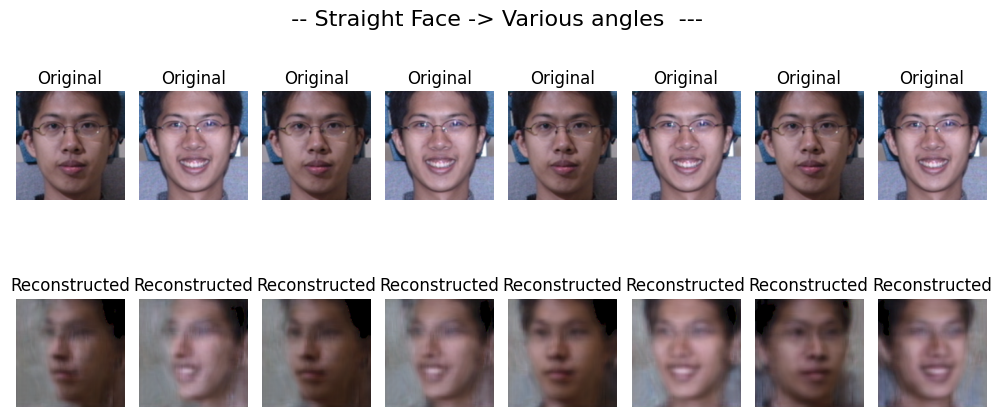

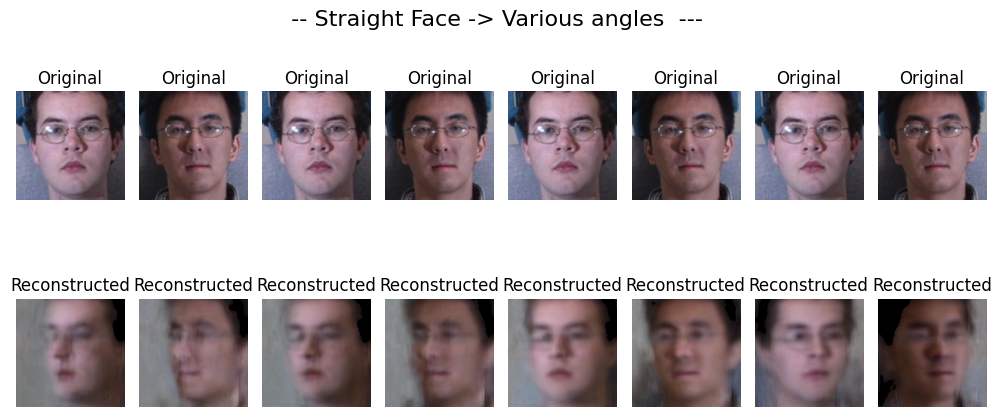

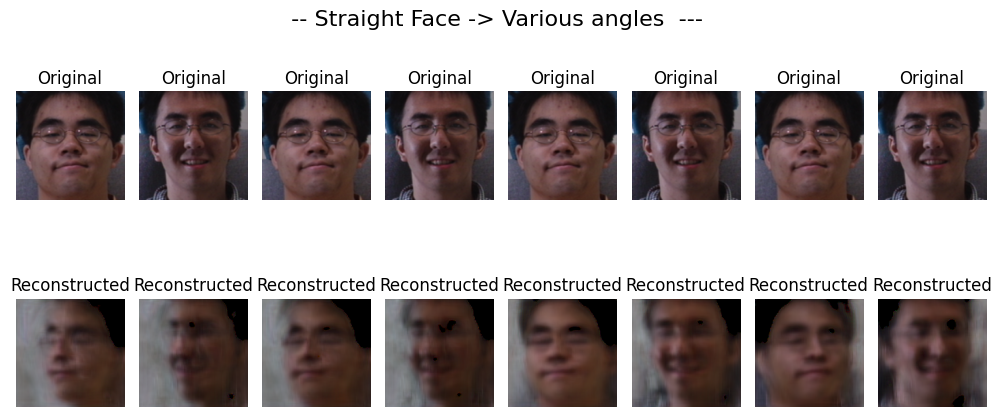

In [ ]:
_, test_dataloader = get_dataloaders()

for i, inputs in enumerate(test_dataloader):
    if i in {0,1,2} :

          original_images, recon_images = test_vae(model1, inputs )
          plot_reconstructions(original_images , recon_images , num_samples=8)
    else:
               break

In [ ]:

generated_path = '/content/drive/MyDrive/major_project/generated_images/'

def save_images(original_images, recon_images,batch_index=0):

    num_samples = original_images.shape[0]
    #print(num_samples)
    for i in range(num_samples):
        # #plt.imshow( (original_images[i] * 255).astype(np.uint8) )
        # print(type(recon_images[i]))

        image_id = 'B' + str(batch_index ) + "_i" + str(i) + '.jpg'

        if i == 0:
              orig_file =  os.path.join(generated_path, 'O_'+image_id)
              image =   Image.fromarray( (original_images[i] * 255).astype(np.uint8) )     #.convert('RGB')
              image.save(orig_file)

        recon_file =  os.path.join(generated_path, 'R_'+image_id)
        image =   Image.fromarray((recon_images[i] * 255).astype(np.uint8))       #.convert('RGB')
        image.save(recon_file)

        #break



In [ ]:
#_, test_dataloader = get_dataloaders()

for i, inputs in enumerate(test_dataloader):
    if i in {1,} :

          original_images, recon_images = test_vae(model1,inputs)
          save_images(original_images , recon_images,batch_index=i)

          if i > 1:
               break

In [ ]:
# _, test_dataloader = get_dataloaders()
# for i, inputs in enumerate(test_dataloader):
#     if i in {1,2,3,4} :

#           original_images, recon_images = test_vae(model1, model2, inputs , refine = True)
#           plot_reconstructions(original_images , recon_images , num_samples=8)

#           if i > 5:
#                break

In [ ]:
#model2=None

In [ ]:
# _, test_dataloader = get_dataloaders()
# for i, inputs in enumerate(test_dataloader):
#     if i in {1,2,3,4} :

#           original_images, recon_images = test_vae(model1, model2, inputs , refine = False)
#           plot_reconstructions(original_images , recon_images , num_samples=8)

#           if i > 4:
#                break

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
from google.colab import runtime
runtime.unassign()